## Hacker Earth Competition 2020

### Business Objective

* Understanding what will be the Burn rate for the employee working in an organization based on the curent pandemic situation where work from home is a boon and bane.



### Purpose

* predict the Burn out rate for each employee in the firm.

In [8]:
pip install catboost

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, r2_score
from tqdm import tqdm_notebook, tqdm
from scipy import stats
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import model_selection
import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from scipy.optimize import minimize
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
warnings.filterwarnings('ignore')

In [2]:
import xgboost
print(xgboost.__version__)

1.4.2


In [3]:
import catboost
print(catboost.__version__)

0.26.1


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [5]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [6]:
test.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4


In [7]:
# getting the counts of each customer
for cols in train.columns:
    print('------------------------------------')
    print(train[cols].value_counts())

------------------------------------
fffe33003000380033003600    1
fffe3400390031003300        1
fffe31003300390031003800    1
fffe32003900360039003800    1
fffe32003500310031003400    1
                           ..
fffe32003300360034003700    1
fffe31003600370039003700    1
fffe32003400390034003500    1
fffe32003400300032003300    1
fffe32003500330032003200    1
Name: Employee ID, Length: 22750, dtype: int64
------------------------------------
2008-01-06    86
2008-05-21    85
2008-02-04    82
2008-07-16    81
2008-07-13    80
              ..
2008-07-06    44
2008-06-27    44
2008-12-24    43
2008-07-04    43
2008-12-07    39
Name: Date of Joining, Length: 366, dtype: int64
------------------------------------
Female    11908
Male      10842
Name: Gender, dtype: int64
------------------------------------
Service    14833
Product     7917
Name: Company Type, dtype: int64
------------------------------------
Yes    12290
No     10460
Name: WFH Setup Available, dtype: int64
----------

In [8]:
print('Total shape of the train', train.shape)
print('Total rows of the train', train.shape[0])
print('Total columns of the train', train.shape[1])

Total shape of the train (22750, 9)
Total rows of the train 22750
Total columns of the train 9


In [9]:
print('Total shape of the test', test.shape)
print('Total rows of the test', test.shape[0])
print('Total columns of the test', test.shape[1])

Total shape of the test (12250, 8)
Total rows of the test 12250
Total columns of the test 8


<AxesSubplot:>

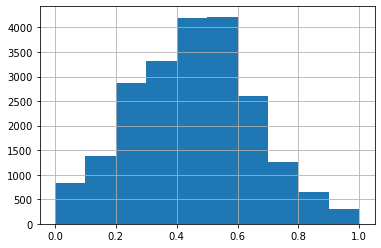

In [10]:
train['Burn Rate'].hist()

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Designation,22750.0,2.178725,1.135145,0.0,1.00,2.00,3.00,5.0
Resource Allocation,21369.0,4.481398,2.047211,1.0,3.00,4.00,6.00,10.0
Mental Fatigue Score,20633.0,5.728188,1.920839,0.0,4.60,5.90,7.10,10.0
Burn Rate,21626.0,0.452005,0.198226,0.0,0.31,0.45,0.59,1.0


In [18]:
train.isnull().sum()


Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [19]:
train.isnull().mean() * 100

Employee ID             0.000000
Date of Joining         0.000000
Gender                  0.000000
Company Type            0.000000
WFH Setup Available     0.000000
Designation             0.000000
Resource Allocation     6.070330
Mental Fatigue Score    9.305495
Burn Rate               4.940659
dtype: float64

In [20]:
test.isnull().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

Ideally, we remove the missing values since its has less impact on the whole data,

In [21]:
train = train.dropna(subset=['Burn Rate', 'Mental Fatigue Score', 'Resource Allocation']).reset_index(drop=True)

In [24]:
print('Total shape of the train', train.shape)
print('Total rows of the train', train.shape[0])
print('Total columns of the train', train.shape[1])

Total shape of the train (18590, 9)
Total rows of the train 18590
Total columns of the train 9


In [25]:
# statistical analysis
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Designation,18590.0,2.179398,1.133148,0.0,1.00,2.00,3.00,5.0
Resource Allocation,18590.0,4.486552,2.044848,1.0,3.00,4.00,6.00,10.0
Mental Fatigue Score,18590.0,5.732173,1.920547,0.0,4.60,5.90,7.10,10.0
Burn Rate,18590.0,0.452444,0.197848,0.0,0.32,0.45,0.59,1.0


In [26]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
3,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
4,fffe3300350037003500,2008-11-26,Male,Product,Yes,2.0,4.0,3.6,0.29


<AxesSubplot:xlabel='Gender', ylabel='count'>

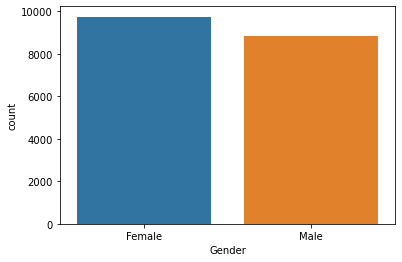

In [28]:
sns.countplot(train['Gender'])

<AxesSubplot:xlabel='Company Type', ylabel='count'>

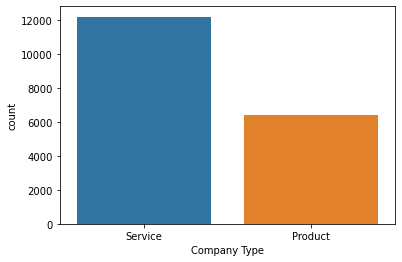

In [29]:
sns.countplot(train['Company Type'])

<AxesSubplot:xlabel='WFH Setup Available', ylabel='count'>

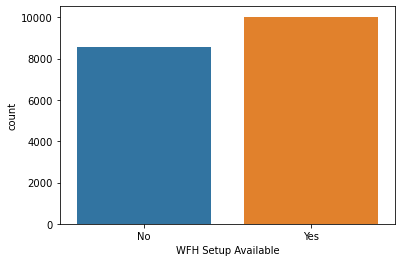

In [30]:
sns.countplot(train['WFH Setup Available'])

<AxesSubplot:xlabel='WFH Setup Available', ylabel='count'>

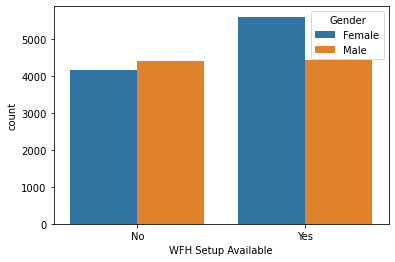

In [31]:
sns.countplot(train['WFH Setup Available'], hue=train['Gender'])

<AxesSubplot:xlabel='Company Type', ylabel='count'>

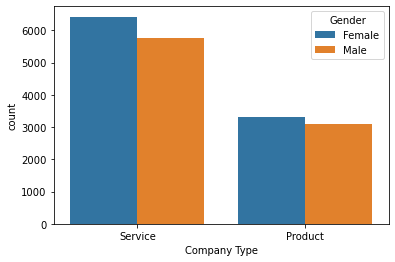

In [32]:
sns.countplot(train['Company Type'], hue=train['Gender'])

<AxesSubplot:>

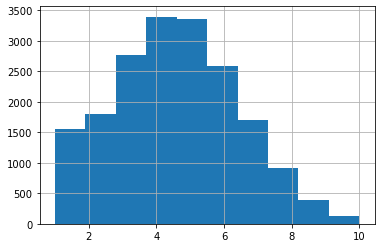

In [33]:
train['Resource Allocation'].hist()

<AxesSubplot:>

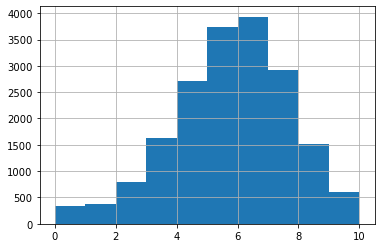

In [34]:
train['Mental Fatigue Score'].hist()

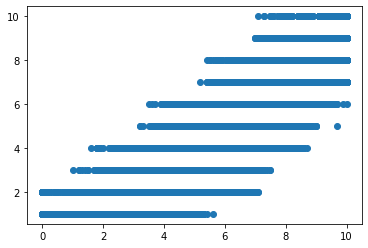

In [35]:
plt.scatter(train['Mental Fatigue Score'], train['Resource Allocation'])

In [36]:
train['Mental Fatigue Score'].corr(train['Resource Allocation'])

0.7995632228418686

In [37]:
train.corr()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Designation,1.000000,0.877893,0.691823,0.736412
Resource Allocation,0.877893,1.000000,0.799563,0.855005
Mental Fatigue Score,0.691823,0.799563,1.000000,0.944389
Burn Rate,0.736412,0.855005,0.944389,1.000000


In [38]:
#train.drop(train.index[14945], inplace=True) # removing the outliers index

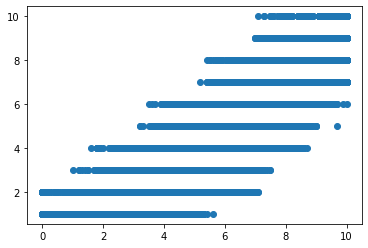

In [39]:
plt.scatter(train['Mental Fatigue Score'], train['Resource Allocation'])

In [40]:
train = train.reset_index(drop=True)

In [41]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
3,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
4,fffe3300350037003500,2008-11-26,Male,Product,Yes,2.0,4.0,3.6,0.29


In [42]:
test_id = test['Employee ID']

In [43]:
# droping columns
train.drop(['Employee ID', 'Date of Joining'], axis=1, inplace=True)
test.drop(['Employee ID', 'Date of Joining'], axis=1, inplace=True)

### Pre process the categorical variable

In [44]:
# ordinal encoding for WFH Setup Available
train['WFH Setup Available'] = train['WFH Setup Available'].map({'Yes':1, 'No':0})
test['WFH Setup Available'] = test['WFH Setup Available'].map({'Yes':1, 'No':0})


# using one hot encoding for no meaningful Ranking

train = pd.get_dummies(data=train,columns=['Gender', 'Company Type'], drop_first=True)
test = pd.get_dummies(data=test,columns=['Gender', 'Company Type'], drop_first=True)

In [45]:
train['Burn Rate'].describe()

count    18590.000000
mean         0.452444
std          0.197848
min          0.000000
25%          0.320000
50%          0.450000
75%          0.590000
max          1.000000
Name: Burn Rate, dtype: float64

In [46]:
train['Mental Fatigue Score'].describe()

count    18590.000000
mean         5.732173
std          1.920547
min          0.000000
25%          4.600000
50%          5.900000
75%          7.100000
max         10.000000
Name: Mental Fatigue Score, dtype: float64

In [47]:
print(train.shape)
print(test.shape)

(18590, 7)
(12250, 6)


In [48]:
train = train[['Mental Fatigue Score','Resource Allocation','Designation','WFH Setup Available',
              'Burn Rate', 'Gender_Male','Company Type_Service']]

In [49]:
test = test[['Mental Fatigue Score','Resource Allocation','Designation','WFH Setup Available',
             'Gender_Male','Company Type_Service']]

# Modelling

In [51]:
X = train.drop('Burn Rate', axis=1)
y = train['Burn Rate']

In [52]:
from sklearn.metrics import accuracy_score,confusion_matrix,log_loss
from sklearn.model_selection import GroupKFold, RepeatedKFold
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=10, shuffle=True, random_state=1)#0#1
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostRegressor(eval_metric='R2',subsample=0.7,bagging_temperature=0.9, l2_leaf_reg=2, n_estimators=1500, learning_rate=0.025)
    
    #CatBoostRegressor(eval_metric='R2',subsample=0.7, l2_leaf_reg=2)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict(X_test)
    print("err: ",r2_score(y_test,preds))
    errcb.append(r2_score(y_test,preds))
    p = m.predict(test)
    y_pred_totcb.append(p)

0:	learn: 0.0425554	test: 0.0425554	test1: 0.0422352	best: 0.0422352 (0)	total: 387ms	remaining: 9m 39s
100:	learn: 0.9151283	test: 0.9151283	test1: 0.9139517	best: 0.9139517 (100)	total: 1.37s	remaining: 18.9s
200:	learn: 0.9268675	test: 0.9268675	test1: 0.9257619	best: 0.9257619 (200)	total: 1.95s	remaining: 12.6s
300:	learn: 0.9285053	test: 0.9285053	test1: 0.9271589	best: 0.9271589 (300)	total: 2.65s	remaining: 10.6s
400:	learn: 0.9295564	test: 0.9295564	test1: 0.9278707	best: 0.9278707 (400)	total: 3.27s	remaining: 8.95s
500:	learn: 0.9304012	test: 0.9304012	test1: 0.9283962	best: 0.9283962 (500)	total: 3.83s	remaining: 7.65s
600:	learn: 0.9310264	test: 0.9310264	test1: 0.9286907	best: 0.9287016 (596)	total: 4.47s	remaining: 6.69s
700:	learn: 0.9315234	test: 0.9315234	test1: 0.9289058	best: 0.9289058 (700)	total: 5.05s	remaining: 5.75s
800:	learn: 0.9319277	test: 0.9319277	test1: 0.9290431	best: 0.9290527 (792)	total: 5.67s	remaining: 4.95s
900:	learn: 0.9322806	test: 0.9322806	te

700:	learn: 0.9317424	test: 0.9317424	test1: 0.9265179	best: 0.9265179 (700)	total: 4.96s	remaining: 5.65s
800:	learn: 0.9321884	test: 0.9321884	test1: 0.9266843	best: 0.9266867 (799)	total: 5.59s	remaining: 4.87s
900:	learn: 0.9325528	test: 0.9325528	test1: 0.9267548	best: 0.9267551 (891)	total: 6.28s	remaining: 4.17s
1000:	learn: 0.9328914	test: 0.9328914	test1: 0.9267789	best: 0.9268065 (962)	total: 6.93s	remaining: 3.46s
1100:	learn: 0.9331846	test: 0.9331846	test1: 0.9268358	best: 0.9268429 (1088)	total: 7.53s	remaining: 2.73s
1200:	learn: 0.9334702	test: 0.9334702	test1: 0.9268523	best: 0.9268619 (1172)	total: 8.21s	remaining: 2.04s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9268618787
bestIteration = 1172

Shrink model to first 1173 iterations.
err:  0.9268618783023514
0:	learn: 0.0425487	test: 0.0425487	test1: 0.0419393	best: 0.0419393 (0)	total: 6.6ms	remaining: 9.89s
100:	learn: 0.9148782	test: 0.9148782	test1: 0.9162808	best: 0.9162808 (100)	total: 

In [53]:
np.mean(errcb)

0.9291808946603183

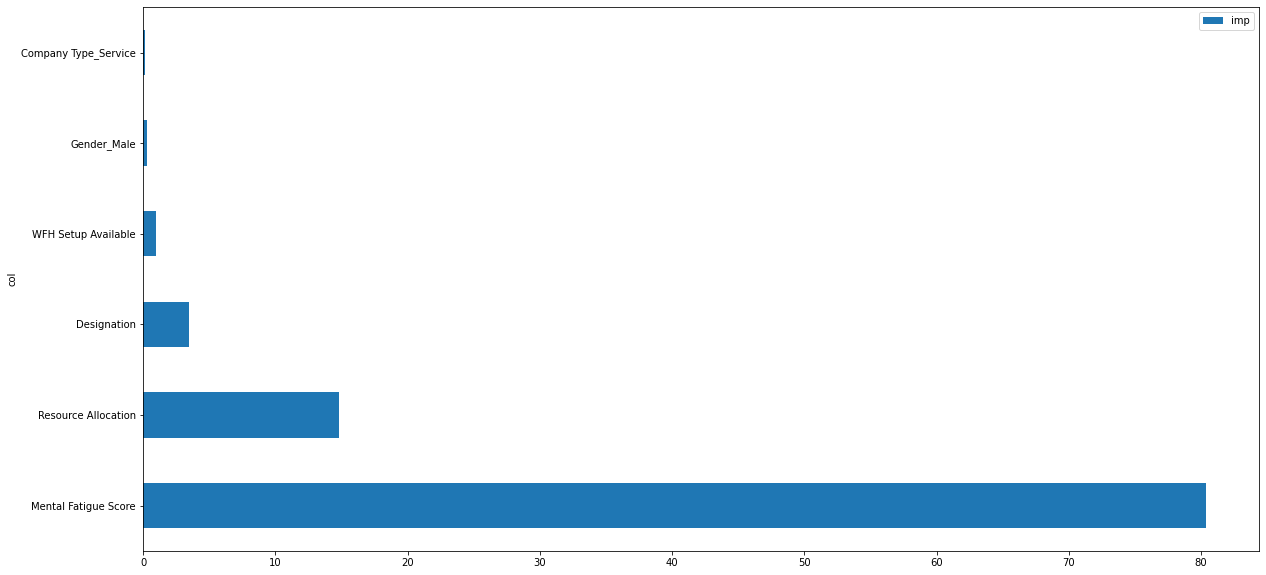

In [54]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [55]:
d = {"Employee ID": test_id, 'Burn Rate': abs((np.mean(y_pred_totcb, 0)))}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Employee ID", 'Burn Rate']]

In [56]:
test_predictions.head()

,Employee ID,Burn Rate
0,fffe31003300390039003000,0.617920
1,fffe31003300310037003800,0.355694
2,fffe33003400380035003900,0.425715
3,fffe3100370039003200,0.378485
4,fffe32003600390036003700,0.531268


In [57]:
test_predictions.to_csv('cat28.csv', index=False)

# Xgboost Model

In [58]:
from xgboost import XGBRegressor

In [59]:
from sklearn.metrics import accuracy_score,confusion_matrix,log_loss
from sklearn.model_selection import GroupKFold, RepeatedKFold
errcb=[]
y_pred_totcb=[]
fold= KFold(n_splits=10, shuffle=True, random_state=10)#25
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m =XGBRegressor(learning_rate=0.1, n_estimator=1500)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict(X_test)
    print("err: ",r2_score(y_test,preds))
    errcb.append(r2_score(y_test,preds))
    p = m.predict(test)
    y_pred_totcb.append(p)

[23:31:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.18492	validation_1-rmse:0.18365
[99]	validation_0-rmse:0.05069	validation_1-rmse:0.05259
err:  0.9282339451416467
[23:31:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.18496	validation_1-rmse:0.18321
[99]	validation_0-rmse:0

In [62]:
np.mean(errcb)

0.9289951421758811

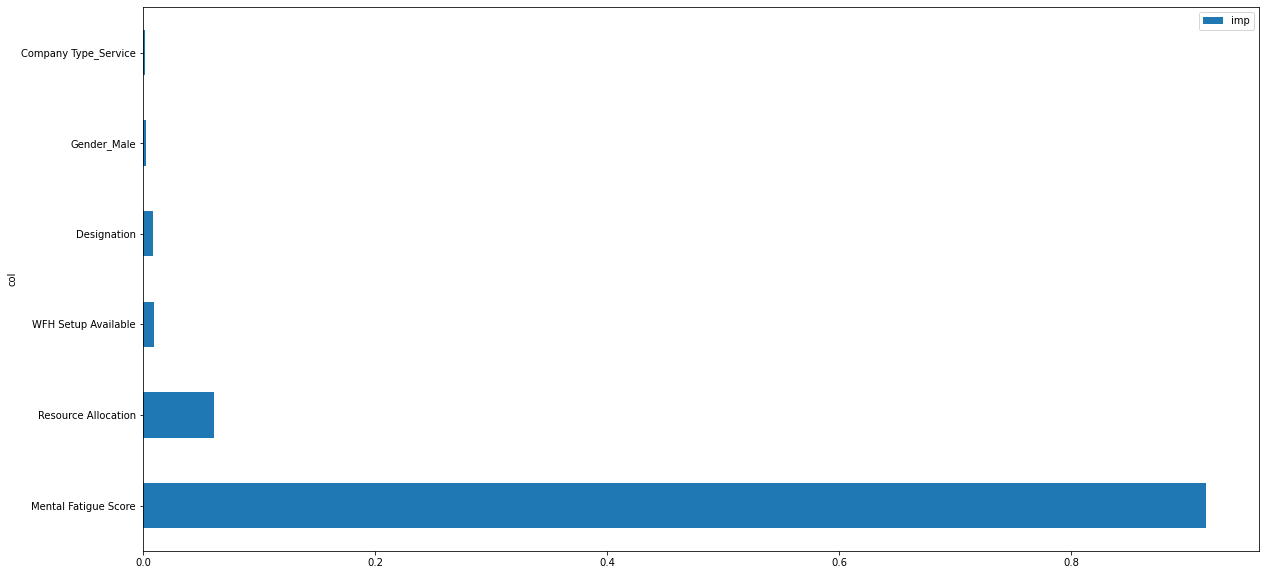

In [63]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [66]:
d = {"Employee ID": test_id, 'Burn Rate': abs(np.mean(y_pred_totcb, 0))}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Employee ID", 'Burn Rate']]

In [67]:
test_predictions.to_csv('xgb17.csv', index=False)

# Ensemble

In [68]:
a = pd.read_csv('cat28.csv')
b = pd.read_csv('xgb17.csv')

In [69]:
a['Burn Rate'].corr(b['Burn Rate'])

0.9997047864074113

In [70]:
a['Burn Rate'] = 0.65 * a['Burn Rate'] + 0.35 * b['Burn Rate']

In [71]:
a.to_csv('stack8.csv', index=False)